# Исследование данных о продажах игр

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Изучение данных

In [1]:
# импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams as rcp
import seaborn as sns
import scipy.stats as st
import warnings

In [2]:
# сохраним данные в виде датафрейма

df = pd.read_csv('/datasets/games.csv')

In [3]:
# выведем общую информацию о датафрейме

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
# выведем первые строки данных

df.head(15)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


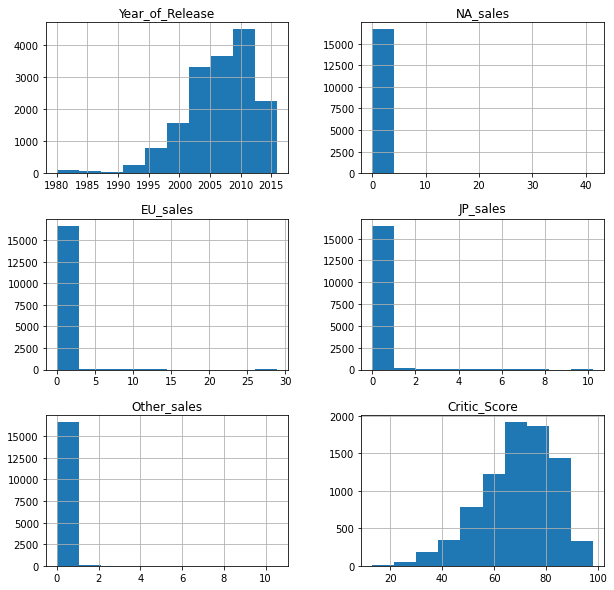

In [5]:
# построим гистограммы для всех столбцов датафрейма с числовыми значениями

df.hist(figsize=(10, 10));

## Предобработка данных

### Переименование столбцов

In [6]:
# переименуем столбцы в соответствии с нижним регистром

df.columns = ['name', 'platform', 'year', 'genre', 'na_sales', 'eu_sales', \
              'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'] 

### Обработка пропусков

In [7]:
# определим количество пропусков в каждом столбце

df.isna().sum()

name               2
platform           0
year             269
genre              2
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score    8578
user_score      6701
rating          6766
dtype: int64

Пропуски присутствуют в 6 столбцах из 11. Как мы видим, пропуски в последних трех столбцах затрагивают значительную долю данных - вплоть до половины. Для двух столбцов количество пропусков составляет 2. Проверим, совпадают ли строки с пропусками для данных столбцов.

#### name и genre

In [8]:
# выведем строки с пропусками в столбце name

df[df['name'].isna()]

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [9]:
# посчитаем отношение данных с пропусками в столбцах name и genre ко всем данным

(len(df[df['name'].isna()]) / len(df)) * 100

0.011965300628178284

Т.к. строки с пропусками в столбцах name и genre составляют совсем незначительную часть данных, будем считать, что их удаление не исказит результаты исследования.

In [10]:
# удалим строки с пропусками в столбцах name и genre

df = df.dropna(subset=['name'])

#### year

In [11]:
# посчитаем отношение данных с пропусками в столбце year ко всем данным

(len(df[df['year'].isna()]) / len(df)) * 100

1.6095255190570215

Т.к. строки с пропусками в столбце year составляют незначительную часть данных, будем считать, что их удаление не исказит результаты исследования.

In [12]:
# удалим строки с пропусками в столбце year

df = df.dropna(subset=['year'])

#### critic_score

In [13]:
# выведем список уникальных значений столбца critic_score

df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [14]:
# выведем строки с пропусками в столбце critic_score

df[df['critic_score'].isna()]

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


В строках с пропусками в столбце critic_score каких-либо закономерностей не наблюдается. Параметров, которые могут быть напрямую или логически связаны с оценкой критиков, также нет. Все уникальные значения столбца находятся в интервале от 0 до 100, что является нормой.

В таком случае оставим пропуски в данных.

#### user_score

In [15]:
# выведем список уникальных значений столбца user_score

df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [16]:
# выведем строки с пропусками в столбце user_score

df[df['user_score'].isna()]

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


В строках с пропусками в столбце user_score каких-либо закономерностей не наблюдается. Параметров, которые могут быть напрямую или логически связаны с оценкой пользователей, также нет.

Однако в списке уникальных значений есть интересное значение - 'tbd'. Скорее всего, данная аббревиатура означает 'То Be Defined', что буквально переводится как "подлежит уточнению". Такие значения следует удалить из датафрейма - они могут исказить исследование.

In [17]:
df['user_score'].isna().sum()

6605

In [18]:
# удалим значения 'tbd' в столбце user_score

df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan

#### rating

In [19]:
# выведем список уникальных значений столбца rating

df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [20]:
# выведем строки с пропусками в столбце rating

df[df['rating'].isna()]

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


В строках с пропусками в столбце rating каких-либо закономерностей не наблюдается. Параметров, которые могут быть напрямую или логически связаны с рейтингом, также нет. Все уникальные значения столбца выглядят правдоподобно.

В таком случае оставим пропуски в данных.

### Изменение типов данных

In [21]:
# вновь выведем общую информацию о датафрейме

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16444 non-null  object 
 1   platform      16444 non-null  object 
 2   year          16444 non-null  float64
 3   genre         16444 non-null  object 
 4   na_sales      16444 non-null  float64
 5   eu_sales      16444 non-null  float64
 6   jp_sales      16444 non-null  float64
 7   other_sales   16444 non-null  float64
 8   critic_score  7983 non-null   float64
 9   user_score    7463 non-null   object 
 10  rating        9768 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Как видно из вывод предыдущей ячейки, все столбцы, за исключением user_score, имеют логически соответствующие типы данных.

Также, в целях экономии памяти, заменим все типы данных float64 на float32.

In [22]:
# изменим типы данных в столбцах

df['user_score'] = df['user_score'].astype('float32')
df['na_sales'] = df['na_sales'].astype('float32')
df['eu_sales'] = df['eu_sales'].astype('float32')
df['jp_sales'] = df['jp_sales'].astype('float32')
df['other_sales'] = df['other_sales'].astype('float32')
df['critic_score'] = df['critic_score'].astype('float32')

### Обработка дубликатов

#### Явные дубликаты

In [23]:
# проверим наличие явных дубликатов в датафрейме

df.duplicated().sum()

0

In [24]:
# проверим наличие дубликатов в столбце name

df['name'].duplicated().sum()

5018

In [25]:
# выведем соответствующие строки

df[df['name'].duplicated()].head(20)

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M
35,Call of Duty: Black Ops II,X360,2012.0,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M
37,Call of Duty: Modern Warfare 3,PS3,2011.0,Shooter,5.54,5.73,0.49,1.57,88.0,3.2,M
41,Call of Duty: Black Ops,PS3,2010.0,Shooter,5.99,4.37,0.48,1.79,88.0,6.4,M
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M
55,Call of Duty: Modern Warfare 2,PS3,2009.0,Shooter,4.99,3.64,0.38,1.60,94.0,6.3,M
57,Grand Theft Auto IV,PS3,2008.0,Action,4.76,3.69,0.44,1.61,98.0,7.5,M
59,Super Mario 64,DS,2004.0,Platform,5.01,3.07,1.25,0.97,NaN,NaN,NaN
69,Call of Duty: Ghosts,PS3,2013.0,Shooter,4.10,3.63,0.38,1.25,71.0,2.6,M
99,Call of Duty: Black Ops 3,XOne,2015.0,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,NaN


In [26]:
# выведем строки с игрой Grand Theft Auto V

df.query('name == "Grand Theft Auto V"')

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M
165,Grand Theft Auto V,XOne,2014.0,Action,2.81,2.19,0.00,0.47,97.0,7.9,M
1730,Grand Theft Auto V,PC,2015.0,Action,0.39,0.69,0.00,0.09,96.0,7.9,M


Как мы видим, хотя в столбце name и присутствуют дубликаты, однако их наличие связано с тем, что одна и та же игра может выходить на разных платформах.

#### Неявные дубликаты

Проверим наличие неявных дубликатов по значениям из столбцов с типом данных object.

In [27]:
print('Количество уникальных значений в столбцах:')
print('name -',  df['name'].nunique())
print('platform -',  df['platform'].nunique())
print('genre -',  df['genre'].nunique(), '\n')
print('Количество уникальных значений в нижнем регистре в столбцах:')
print('name -',  df['name'].str.lower().nunique())
print('platform -',  df['platform'].str.lower().nunique())
print('genre -',  df['genre'].str.lower().nunique())

Количество уникальных значений в столбцах:
name - 11426
platform - 31
genre - 12 

Количество уникальных значений в нижнем регистре в столбцах:
name - 11426
platform - 31
genre - 12


Неявных дубликатов не обнаружено.

### Добавление новых столбцов

Добавим в датафрейм столбец с суммарными продажами игр во всех регионах.

In [28]:
df['total_sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis=1)

### Обработка аномальных значений

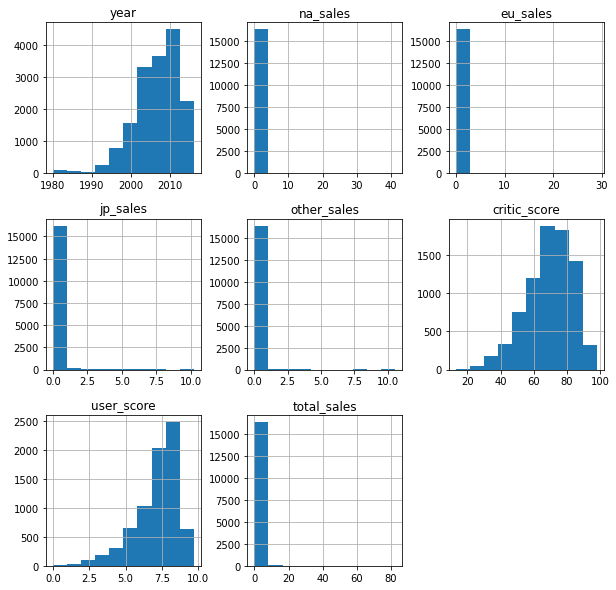

In [29]:
# построим гистограммы для всех столбцов обновленного датафрейма с числовыми значениями

df.hist(figsize=(10, 10));

На гистограммах для столбцов с годами релиза, оценками и рейтингом заметно, что все значения распределены с достаточно немалой частотой.

На гистограммах для столбцов с продажами наблюдается один ярко выраженных пик вблизи значения 0, а далее график практически сливается с осью абсцисс. Хотя такое распределение значений напоминает распределение данных с аномалиями, тем не менее следует учитывать, что в данных столбцах отражены продажи игр в миллионах копий. Это значит, что миллионы людей купили данные игры. Учитывая данный фактор, следует принять, что такие данные не являются аномалиями.

## Исследовательский анализ данных

### Анализ релиза игр по годам

In [31]:
print('Минимальный год релиза -', df['year'].min().astype('int'))
print('Максимальный год релиза -', df['year'].max().astype('int'))

Минимальный год релиза - 1980
Максимальный год релиза - 2016


In [32]:
# выведем уникальные значения столбца year, отсортированные по убыванию частоты выпуска игр

df['year'].value_counts()

2008.0    1427
2009.0    1426
2010.0    1255
2007.0    1197
2011.0    1136
2006.0    1006
2005.0     939
2002.0     829
2003.0     775
2004.0     762
2012.0     653
2015.0     606
2014.0     581
2013.0     544
2016.0     502
2001.0     482
1998.0     379
2000.0     350
1999.0     338
1997.0     289
1996.0     263
1995.0     219
1994.0     121
1993.0      60
1981.0      46
1992.0      43
1991.0      41
1982.0      36
1986.0      21
1989.0      17
1983.0      17
1987.0      16
1990.0      16
1988.0      15
1984.0      14
1985.0      14
1980.0       9
Name: year, dtype: int64

In [33]:
# выведем отношение числа игр, выпущенных в период с 2005 по 2012 год, к общему числу игр

len(df.query('2001 < year < 2012')) / len(df)

0.6538555096083678

In [34]:
print('Cреднее количество игр, выпущенных за один год   ', round(df['year'].value_counts().mean(), 1))
print('Медианное количество игр, выпущенных за один год ', df['year'].value_counts().median())

Cреднее количество игр, выпущенных за один год    444.4
Медианное количество игр, выпущенных за один год  338.0


In [35]:
# рассчитаем количество игр, выпущенных в 80-e годы

print('Количество игр, выпущенных в 80-e годы:        ', len(df.query('1980 < year < 1989')))
print('Количество игр, выпущенных в 90-e годы:        ', len(df.query('1990 < year < 1999')))
print('Количество игр, выпущенных в 00-e годы:        ', len(df.query('2000 < year < 2009')))
print('Количество игр, выпущенных с 2010 по 2016 год: ', len(df.query('2010 < year < 2016')))

Количество игр, выпущенных в 80-e годы:         179
Количество игр, выпущенных в 90-e годы:         1415
Количество игр, выпущенных в 00-e годы:         7417
Количество игр, выпущенных с 2010 по 2016 год:  3520


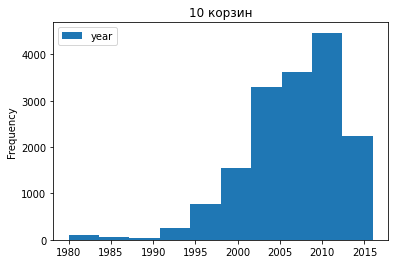

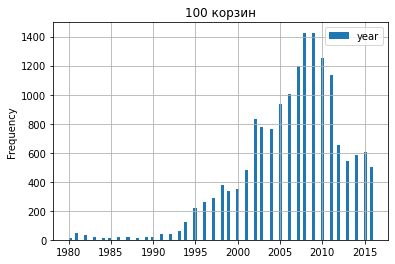

In [36]:
# построим гистограммы для столбца year

df.plot(y='year', kind='hist', bins=10, title='10 корзин');
df.plot(y='year', kind='hist', bins=100, title='100 корзин', grid=True);

Мы получили следуюшие данные:
- в датафрейме представлены данные о релизах игр с 1980 по 2016 года включительно;
- наибольшее количество игр было выпущено в 2008 году - почти 1500, наименьшее - в 1980 - 9;
- среднее количество игр, выпущенных за один год, составляет 444;
- медианное количество игр, выпущенных за один год, составляет 338;
- в 80-е годы было выпущено 179 игры, в 90-е - 1415, в 00-е - 7417, с 2010 по 2016 года - 3520.

**По полученным данным можно сделать следующие выводы**:
- начиная с 2002 года заметен скачок количества выпущенных за год игр: вплоть до 2011 года этот параметр составляет не менее 750;
- кроме того, в период с 2002 по 2011 года были выпущены две трети игр;
- до 2011 года включительно наблюдается тенденция к увеличению количества выпущенных за год игр, после - тенденция к уменьшению;
- в связи с полученными данными можно выделить 5 временных периодов:
 - 1980-1993 - период становления игровой индустрии: ежегодно выходят не более 60 игр;
 - 1994-2001 - период бурного роста: количество выпускаемых игр увеличивается со 121 до 482;
 - 2002-2009 - "золотой" период индустрии: в год выпускается не менее 750 игр, в период с 2005 года - не менее 900, с 2006 - не менее 1000; пик приходится на 2008 год - почти 1.5 тысячи выпущенных игр;
 - 2010-2011 - период плавного спада: за 2010 год выходит менее 1300 игр, за 2011 - чуть более 1100;
 - 2012-2016 - период резкого спада: в 2012 году выходит 653 игра, далее - менее 600 игр в год.

### Анализ продаж по платформам

In [37]:
# выведем отсортированный сириэс с суммарными продажами игр для каждой платформы

(
    df.groupby('platform')['total_sales'].sum()
    .sort_values(ascending=False)
)

platform
PS2     1233.559937
X360     961.239990
PS3      931.339966
Wii      891.179993
DS       802.780029
PS       727.580017
PS4      314.140015
GBA      312.880005
PSP      289.529999
3DS      257.809998
PC       255.759995
GB       254.429993
XB       251.569992
NES      251.050003
N64      218.009995
SNES     200.039993
GC       196.729996
XOne     159.320007
2600      86.480003
WiiU      82.190002
PSV       53.810001
SAT       33.590000
GEN       28.350000
DC        15.950000
SCD        1.860000
NG         1.440000
WS         1.420000
TG16       0.160000
3DO        0.100000
GG         0.040000
PCFX       0.030000
Name: total_sales, dtype: float32

Сделаем предположение о том, что средние года релиза игр для платформ с наибольшими суммарными продажами игр лежат ближе к нашему времени.

In [38]:
# сохраним сириэс в переменную

top_sales_platforms = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

In [39]:
# напишем цикл, который запишет значение среднего года релиза игры для каждой платформы

for i in df['platform'].unique():
    top_sales_platforms[i] = df[df['platform'] == i]['year'].mean()

In [40]:
top_sales_platforms

platform
PS2     2004.583862
X360    2009.880737
PS3     2010.840698
Wii     2008.966553
DS      2008.185303
PS      1998.005859
PS4     2015.145386
GBA     2003.210815
PSP     2008.731812
3DS     2013.126953
PC      2008.914307
GB      1995.958740
XB      2003.636353
NES     1987.153076
N64     1998.531616
SNES    1993.845215
GC      2003.400391
XOne    2014.951416
2600    1982.137939
WiiU    2013.659912
PSV     2014.132812
SAT     1996.028931
GEN     1993.036987
DC      1999.942261
SCD     1993.833374
NG      1994.500000
WS      2000.000000
TG16    1995.000000
3DO     1994.666626
GG      1992.000000
PCFX    1996.000000
Name: total_sales, dtype: float32

Как мы видим, предположение оправдалось: средние года релиза для 8 из топ 11 платформ с наибольшими суммарными продажами игр лежат в промежутке между 2002 и 2011 годами - в этот период было выпущено подавляющее большинство игр. Мы можем сделать вывод о связи между количеством проданных копий игры и платформой выхода игры.

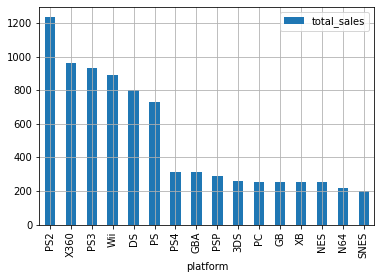

In [41]:
# построим столбчатую диаграмму для датафрейма с суммарными продажами игр
# для каждой платформы для значений более 200 миллионов проданных копий

(
    pd.DataFrame(df.groupby('platform')['total_sales'].sum().sort_values(ascending=False))
    .query('total_sales > 200')
    .plot(y='total_sales', kind='bar', grid=True)
);

Построим графики распределения по годам (столбчатые диаграммы) для платформ с наибольшими суммарными продажами игр, а именно для PS2, X360, PS3, Wii, DS и PS, как для платформ с количеством проданных копий игр более 700 миллионов.

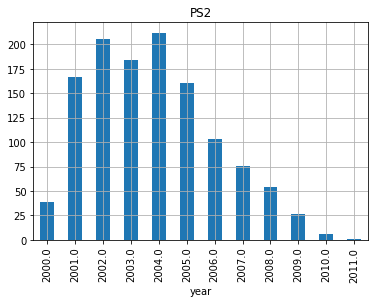

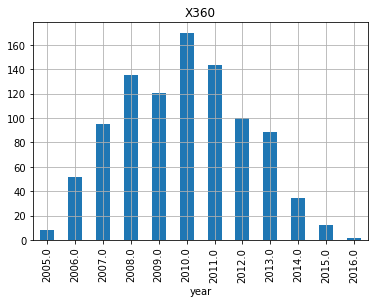

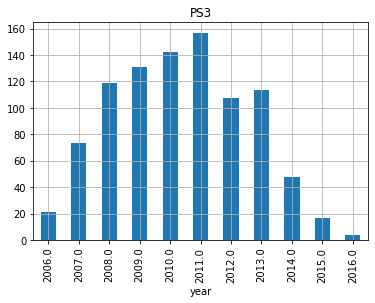

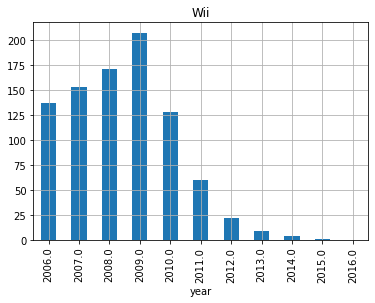

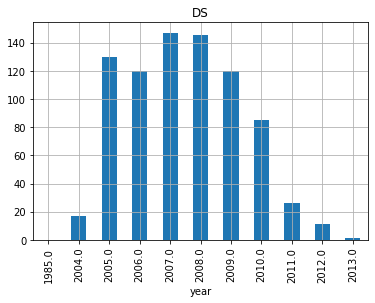

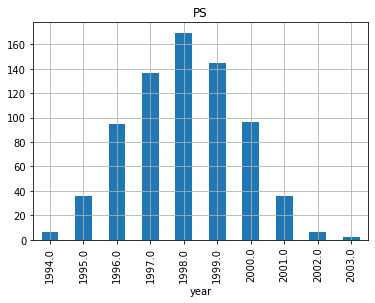

In [42]:
def plot_year_distribution(platform):
    (
        df.query('platform == "{}"'.format(platform))
        .groupby('year')['total_sales'].sum()
        .plot(y='total_sales', kind='bar', grid=True, title=platform)
    );
    
platforms_to_plot = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

for plat in platforms_to_plot:
    plot_year_distribution(plat)
    plt.show()

Благодаря визуализации в данных был обнаружен артефакт: значение, соответствующее 1985 году и платформе DS.

In [43]:
df.query('platform == "DS" and year == 1985')

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.0,0.0,0.02,0.0,NaN,NaN,NaN,0.02


Однако в 1985 такой платформы еще не существовало. Удалим данную строку.

In [44]:
df = df.drop(df.query('platform == "DS" and year == 1985').index)

Из столбчатых диаграмм видно, что для всех платформ из топ 6, кроме PS, пики на графиках приходятся на период с 2003 по 2011 года, когда было выпущено преобладающее число игр.

Также по графикам заметно, что **в данных наблюдается характерный срок, когда появляются новые платформы и исчезают старые: этот срок составляет 8-11 лет**.

### Определение актуального периода

Исходя из предыдущих двух анализов можно сделать вывод о том, что за актуальный период следует принять такой промежуток времени, который будет соответствовать следующим условиям:
- года внутри промежутка будут находится вместе с прогнозируемым 2017 годом в одном периоде (из вывода анализа релиза игр по годам), а именно в периоде резкого спада: 2012-2016;
- года внутри промежутка должны стать годами первых релизов игр на новых платформах - это связано с тем, что срок появления и исчезновения платформ составляет 8-11 лет.

На основе данных за соответствующий актуальный период можно будет сделать прогноз на 2017 год, т.к:
- года будет принадлежать одному периоду развития индустрии, следовательно, релизы и продажи должны будут осуществляться по одному закону;
- в 2017 году продолжат выходить игры на новых платформах, срок жизни которых еще не истечет.

Проверим, выходили ли релизы на новых платформах в период с 2012 года.

In [45]:
# выведем список годов, в которые произошли первые релизы на новых платформах

df.groupby('platform')['year'].min().sort_values(ascending=False)

platform
XOne    2013.0
PS4     2013.0
WiiU    2012.0
3DS     2011.0
PSV     2011.0
PS3     2006.0
Wii     2006.0
X360    2005.0
PSP     2004.0
DS      2004.0
GC      2001.0
GBA     2000.0
XB      2000.0
PS2     2000.0
WS      1999.0
DC      1998.0
PCFX    1996.0
N64     1996.0
TG16    1995.0
SAT     1994.0
PS      1994.0
3DO     1994.0
SCD     1993.0
NG      1993.0
GG      1992.0
SNES    1990.0
GEN     1990.0
GB      1988.0
PC      1985.0
NES     1983.0
2600    1980.0
Name: year, dtype: float64

Учитывая вышеописанные условия, **в качестве актуального периода принимаем промежуток с 2012 по 2016 год включительно**.

**Перезапишем датафрейм, оставив в нем данные исключительно за актуальный период**.

In [46]:
df = df.query('year > 2011')

### Исследование прибыльности платформ

In [47]:
# выведем сириэс с платформами по наибольшим продажам игр

(
    df.groupby('platform')['total_sales'].sum()
    .sort_values(ascending=False)
)

platform
PS4     314.140015
PS3     288.790009
X360    236.540009
3DS     194.610001
XOne    159.320007
WiiU     82.190002
PC       62.650002
PSV      49.180000
Wii      35.369999
DS       12.550000
PSP      11.190000
Name: total_sales, dtype: float32

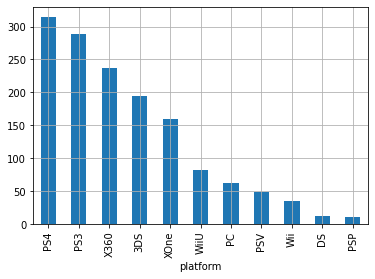

In [48]:
# построим столбчатую диаграмму для полученных данных

(
    df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
    .plot(y='total_sales', kind='bar', grid=True)
);

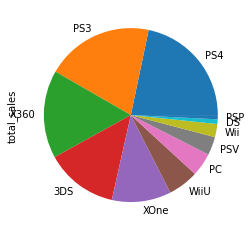

In [49]:
# построим круговую диаграмму для полученных данных

(
    df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
    .plot(y='total_sales', kind='pie', grid=True)
);

**Построим столбчатые диаграммы для платформ с числом продаж более 50 миллионов копий - именно такие платформы являются лидерами по продажам**.

Однако следует учесть, что ввиду общего падения игровой индустрии в течение актуального периода строить графики по абсолютным величинам продаж будет некорректно. В таком случае построим столбчатые диаграммы для каждой платформы по доле продаж по годам.

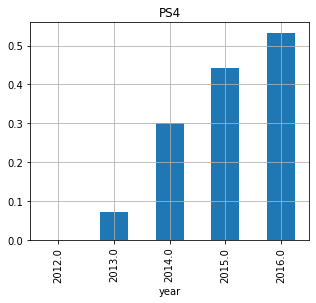

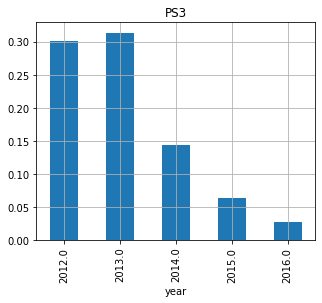

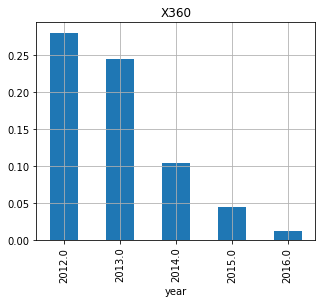

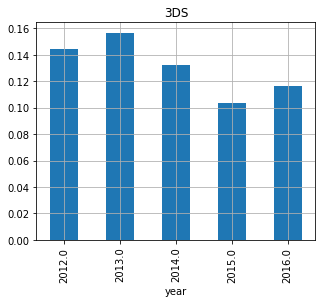

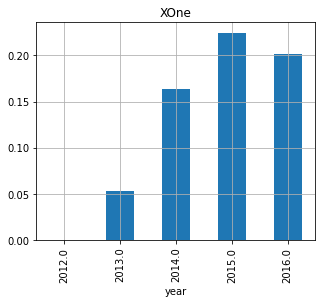

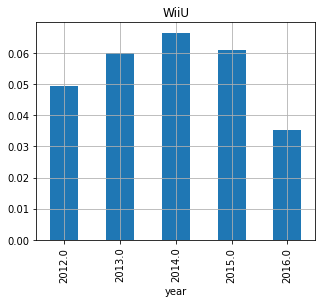

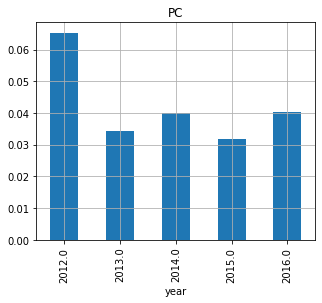

In [50]:
def plot_diagram(platform):
    (
        (
            (df.query('platform == "{}"'.format(platform)).groupby('year')['total_sales'].sum()) /
            (df.groupby('year')['total_sales'].sum())
        )
        .plot(y='total_sales', kind='bar', grid=True, title=platform, figsize=(5, 4))
    );
    
platforms_to_plot_diag = ['PS4', 'PS3', 'X360', '3DS', 'XOne', 'WiiU', 'PC']

for plat in platforms_to_plot_diag:
    plot_diagram(plat)
    plt.show()

Из полученных диаграмм видно, что представленные платформы можно разбить на следующие группы:
- платформы, жизненный цикл которых подходит к концу - продажи падают:
 - PS3
 - X360
- платформы, жизненный цикл которых берет свое начало - продажи растут:
 - PS4
 - XOne
- платформы, для которых не наблюдается четкой тенденции к падению или росту продаж:
 - 3DS
 - WiiU
 - PC
 
Логично предположить, что **потенциально прибыльными платформами можно считать оные, относящиеся к группе роста продаж, а именно PS4 и XOne**.

### Анализ характера разброса данных

Построим диаграммы размаха ("ящики с усами") по продажам игр для каждой платформы.

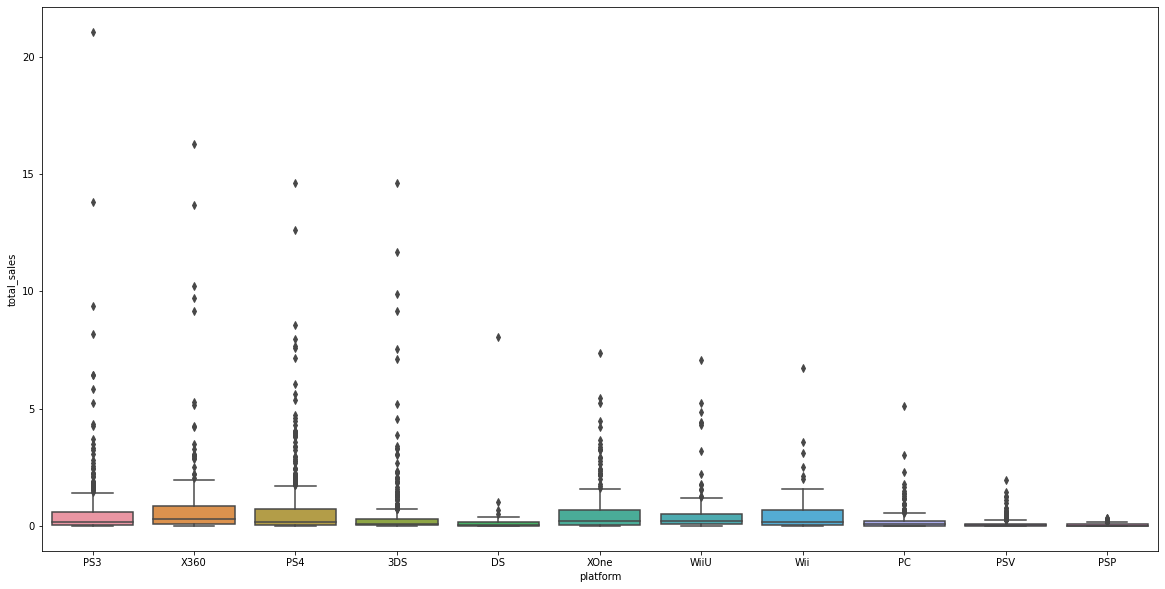

In [51]:
rcp['figure.figsize'] = 20,10

ax = sns.boxplot(x='platform', y="total_sales", data=df)

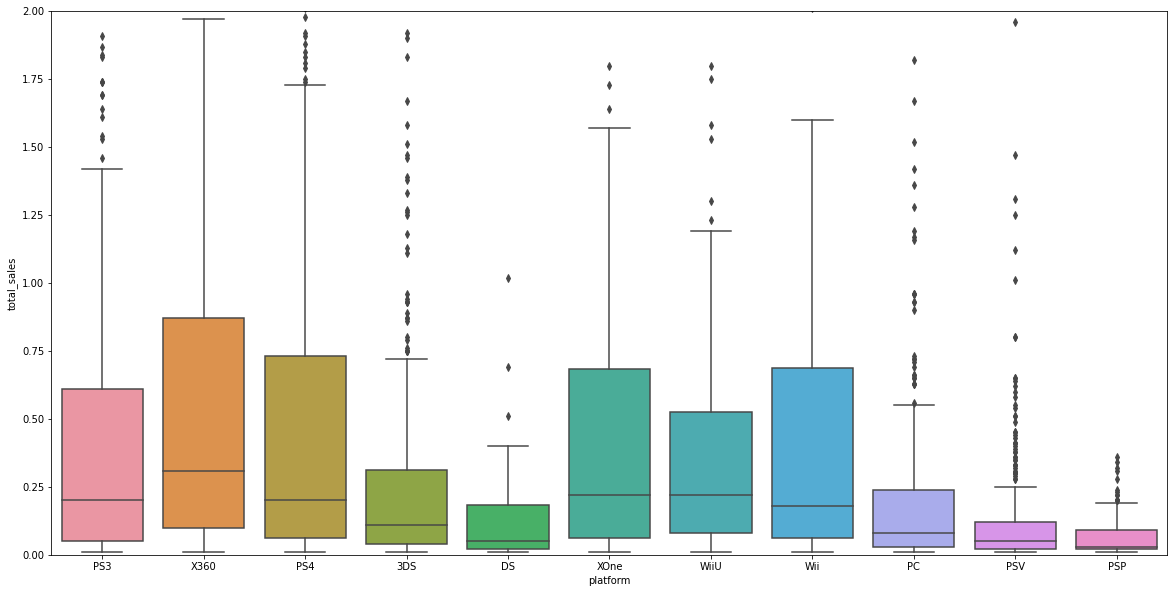

In [52]:
ax = sns.boxplot(x='platform', y="total_sales", data=df)

ax.set_ylim([0, 2]);

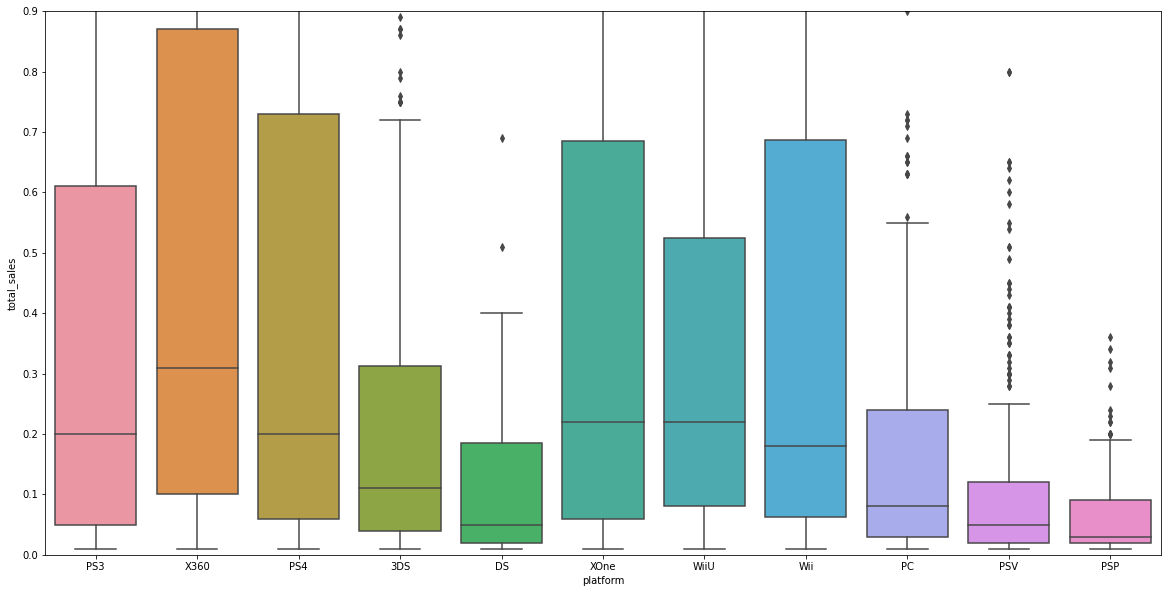

In [53]:
ax = sns.boxplot(x='platform', y="total_sales", data=df)

ax.set_ylim([0, 0.9]);

In [54]:
# выведем общую статистическую информацию по продажам игр для каждой платформы

for i in df['platform'].unique():
    print(i, '\n')
    print(df[df['platform'] == i]['total_sales'].describe(), '\n\n')

PS3 

count    493.000000
mean       0.585781
std        1.462855
min        0.010000
25%        0.050000
50%        0.200000
75%        0.610000
max       21.049999
Name: total_sales, dtype: float64 


X360 

count    292.000000
mean       0.810069
std        1.712069
min        0.010000
25%        0.100000
50%        0.310000
75%        0.870000
max       16.270000
Name: total_sales, dtype: float64 


PS4 

count    392.000000
mean       0.801378
std        1.609456
min        0.010000
25%        0.060000
50%        0.200000
75%        0.730000
max       14.630000
Name: total_sales, dtype: float64 


3DS 

count    396.000000
mean       0.491439
std        1.387161
min        0.010000
25%        0.040000
50%        0.110000
75%        0.312500
max       14.599999
Name: total_sales, dtype: float64 


DS 

count    31.000000
mean      0.404839
std       1.439245
min       0.010000
25%       0.020000
50%       0.050000
75%       0.185000
max       8.060000
Name: total_sales, dtype: floa

**По полученным данным можно сделать следующие выводы**:
- медианы продаж игр для платформ лежат в интервале от 30 тысяч до 310 тысяч;
- первые квартили находятся достаточно близко друг к другу: наименьшее значение составляет 20 тысяч, наибольшее - 100 тысяч;
- третьи квартили достаточно широко разбросаны: наименьшее значение - 173 тысячи, наибольшее - 870 тысяч;
- распределение границ статистически значимой выборки имеет схожую с распределением квартилей природу: нижние границы расположены близко друг к другу, верхние - разбросаны и находятся в промежутке между ~180 тысячами и ~2 миллионами;
- для всех платформ наблюдаются выбросы: для PSP все они лежат в интервале до 330 тысяч, для PS3, X360, PS4 и 3DS отдельные значения превышают 20-14 миллионов;
- данные для некоторых платформ (PSP, PSV, DS) сгруппированы достаточно плотно, для других (X360, PS4) - достаточно широко разбросаны;
- для графиков всех платформ характерна асимметрия - медиана значительно ближе расположена к первому квартилю, нежели к третьему;
- в целом данные смещены в сторону нижней границы значений.

### Исследование влияния отзывов пользователей и критиков на продажи

Для каждой пары параметров - общие продажи-оценка критиков и общие продажи-оценка пользователей - построим диаграммы рассеяния для случайных платформ, а также рассчитаем коэффициенты корреляции.

Для начала рассчитаем общие коэффициенты Пирсона.

In [55]:
# вычислим коэффициент корреляции Пирсона для столбцов total_sales и critic_score

df['total_sales'].corr(df['critic_score']) * 100

30.819674816167563

In [56]:
# вычислим коэффициент корреляции Пирсона для столбцов total_sales и user_score

df['total_sales'].corr(df['user_score']) * 100

0.4428819763759416

#### total_sales и critic_score

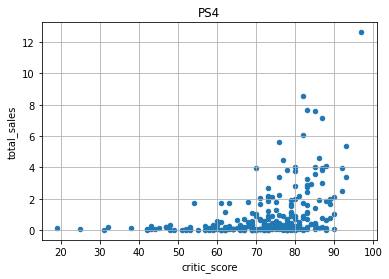

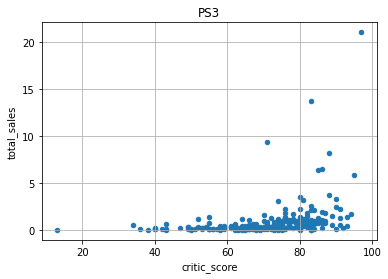

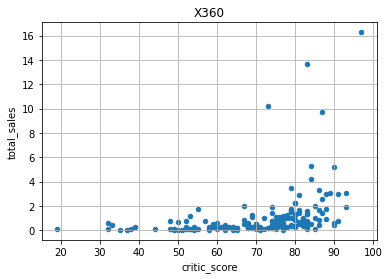

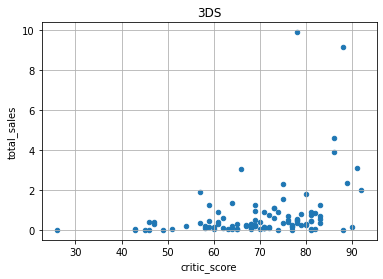

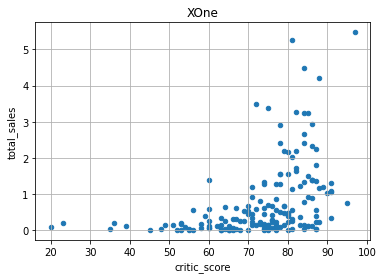

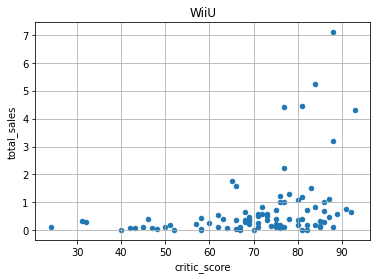

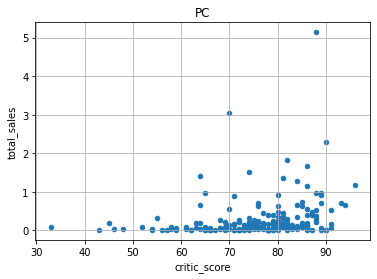

In [57]:
# построим диаграммы рассеяния для столбцов total_sales и critic_score для разных платформ

def plot_scatter_critic_score(platform):
    (
        df.query('platform == "{}"'.format(platform))
        .plot(y='total_sales', x='critic_score', kind='scatter', grid=True, title=platform)
    );

rcp['figure.figsize'] = 6,4
    
for plat in platforms_to_plot_diag:
    plot_scatter_critic_score(plat)
    plt.show()

In [58]:
# вычислим коэффициенты корреляции Пирсона для столбцов total_sales и critic_score для разных платформ

for plat in platforms_to_plot_diag:
    print(f'Коэффициент корреляции Пирсона для    {plat}      ',
          df.query('platform == "{}"'.format(plat))
          ['total_sales'].corr(df['critic_score']) * 100)

Коэффициент корреляции Пирсона для    PS4       40.65679010283493
Коэффициент корреляции Пирсона для    PS3       33.149726565243334
Коэффициент корреляции Пирсона для    X360       36.05734915841888
Коэффициент корреляции Пирсона для    3DS       32.080286662937326
Коэффициент корреляции Пирсона для    XOne       41.69983268440011
Коэффициент корреляции Пирсона для    WiiU       34.83797599500602
Коэффициент корреляции Пирсона для    PC       23.724323875744275


Выводы:
- по графикам нельзя сделать однозначный вывод о наличии взаимосвязи между исследуемыми параметрами: **на всех графиках заметно, что игры с продажами до 1 миллиона копий встречаются довольно часто по всей оси абсцисс: вне зависимости от оценки критиков**;
- однако, практически все игры с количеством проданных копий более 2 миллионов имеют оценку критиков не менее 70;
- коэффициенты корреляции Пирсона варьируются от 24 до 42 процентов, притом для платформ, которые показывают рост продаж - PS4 и XOne - коэффициенты являются наиболее высокими и составляют 41 и 42 процента соответственно;
- такие коэффициенты корреляции, как и общий для всех платформ коэффициент 31 %, говорят о наличии умеренной связи (для PC - слабой). Однако данный показатель достаточно мал для того, чтобы сделать вывод о наличии высокой или хотя бы заметной связи между исследуемыми параметрами.

Общий вывод: полученные данные говорят о том, что **утверждать о влиянии отзывов критиков на продажи нельзя**.

#### total_sales и user_score

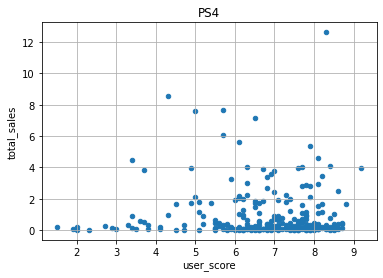

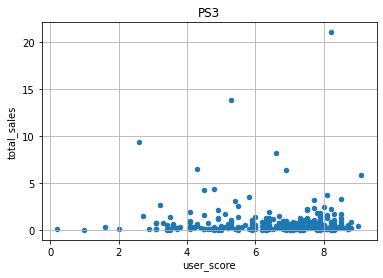

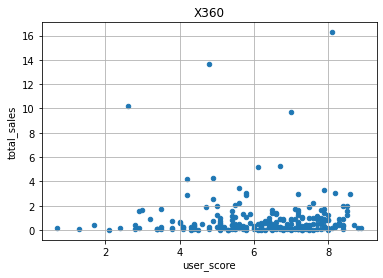

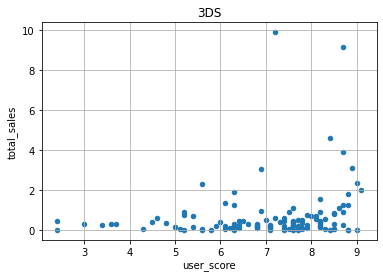

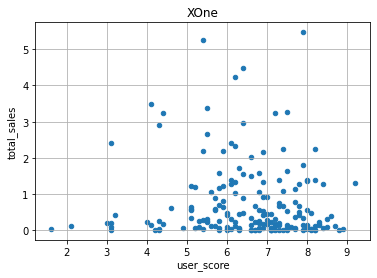

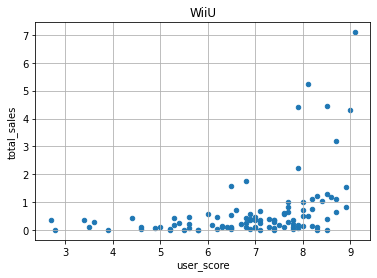

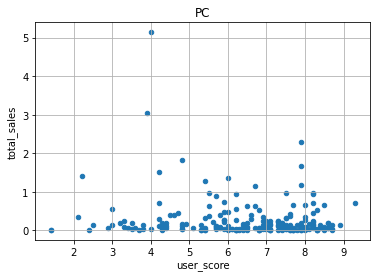

In [59]:
# построим диаграммы рассеяния для столбцов total_sales и user_score

def plot_scatter_user_score(platform):
    (
        df.query('platform == "{}"'.format(platform))
        .plot(y='total_sales', x='user_score', kind='scatter', grid=True, title=platform)
    );

for plat in platforms_to_plot_diag:
    plot_scatter_user_score(plat)
    plt.show()

In [60]:
# вычислим коэффициенты корреляции Пирсона для столбцов total_sales и user_score для разных платформ

for plat in platforms_to_plot_diag:
    print(f'Коэффициент корреляции Пирсона для    {plat}      ',
          df.query('platform == "{}"'.format(plat))
          ['total_sales'].corr(df['user_score']) * 100)

Коэффициент корреляции Пирсона для    PS4       -3.1957105603966944
Коэффициент корреляции Пирсона для    PS3       -0.5143516388468056
Коэффициент корреляции Пирсона для    X360       0.6163989294609677
Коэффициент корреляции Пирсона для    3DS       19.758260667329857
Коэффициент корреляции Пирсона для    XOne       -6.892505829722281
Коэффициент корреляции Пирсона для    WiiU       40.02190371566136
Коэффициент корреляции Пирсона для    PC       -12.186748143927082


Выводы:
- по данным графикам скорее можно сделать вывод об отсутствии взаимосвязи между исследуемыми параметрами, а не о ее наличии: **на всех графиках заметно, что игры с продажами до 1 миллиона копий встречаются довольно часто по всей оси абсцисс: вне зависимости от оценки пользователей**, а для PS4 и XOne по всей оси абсцисс встречаются игры с с продажами вплоть до 5 миллионов;
- модули коэффициентов корреляции Пирсона варьируются от 0.5 до 40 процентов, притом для 4 из 7 платформ они не более 7, для 6 из 7 - не более 20;
- для растущих / падающих платформ не наблюдаются характерные коэффициенты корреляции, отличные от прочих;
- коэффициенты Пирсона, составляющие менее 10 %, в том числе общий для всех платформ коэффициент 0.4 %, говорят либо об отсутствии взаимосвязи между исследуемыми параметрами, либо о ее более сложном характере;
- коэффициенты корреляции, составляющие от 10 до 30 %,  говорят о наличии слабой связи между исследуемыми параметрами;
- коэффициент Пирсона для WiiU, равный 40 %, говорит о наличии умеренной связи. Однако данный показатель достаточно мал для того, чтобы сделать вывод о наличии высокой или хотя бы заметной связи между исследуемыми параметрами.

Общий вывод: полученные данные говорят о том, что **утверждать о влиянии отзывов пользователей на продажи нельзя**.

### Исследование прибыльности жанров

In [61]:
# выведем сириэс с жанрами по количеству игр

df['genre'].value_counts()

Action          1031
Role-Playing     370
Adventure        302
Sports           268
Shooter          235
Misc             192
Racing           115
Fighting         109
Platform          85
Simulation        80
Strategy          71
Puzzle            28
Name: genre, dtype: int64

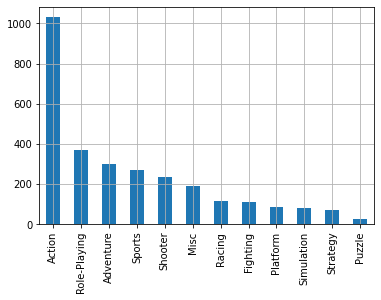

In [62]:
# для полученных данных построим столбчатую диаграмму

(
    df['genre'].value_counts()
    .plot(kind='bar', grid=True)
);

Однозначным лидером среди жанров по количеству игр является action: на него приходится более 1000 наименований. На следующие следом за ним Role-Playing, Adventure, Sports и Shooter приходятся от 370 до 235 игр соответственно, что составляет значительную разницу в сравнении с количеством игр для action.

Внизу топа располагаются жанры Puzzle, Strategy и Simulation с 28, 71 и 80 выпущенными играми соответственно.

**Изучим распределение прибыли по жанрам**.

In [63]:
# выведем датафрейм с жанрами по медианным продажам игр

(
    df.groupby('genre')['total_sales'].median()
    .sort_values(ascending=False)
)

genre
Shooter         0.440
Sports          0.240
Platform        0.210
Racing          0.140
Role-Playing    0.140
Fighting        0.130
Action          0.120
Misc            0.120
Simulation      0.120
Strategy        0.080
Puzzle          0.045
Adventure       0.030
Name: total_sales, dtype: float32

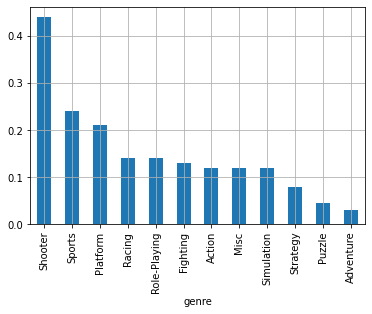

In [64]:
# для полученных данных построим столбчатую диаграмму

(
    df.groupby('genre')['total_sales'].median()
    .sort_values(ascending=False)
    .plot(kind='bar', grid=True)
);

В данных по медианным продажам игр среди всех жанров выделяется Shooter: медианное значение мировых продаж составляет более 400 тысяч копий игр данного жанра.

Для жанров Sports и Platform, которые следуют в топе после шутера, медианное количество продаж составляет более 200 тысяч. Следует отметить, что 3 жанра из топ 5 по медианным продажам также входят в топ 5 по количеству выпущенных игр.

Жанр Action, который лидирует по количеству выпущенных игр, занимает в данном рейтинге лишь 7 позицию с показателем 120 тысяч.

Внизу данного топа располагаются жанры Adventure, Puzzle и Strategy с медианными значениями 30, 45 и 80 тысячами проданных копий соответственно. 2 из 3 данных жанров также находятся внизу предыдущего топа.

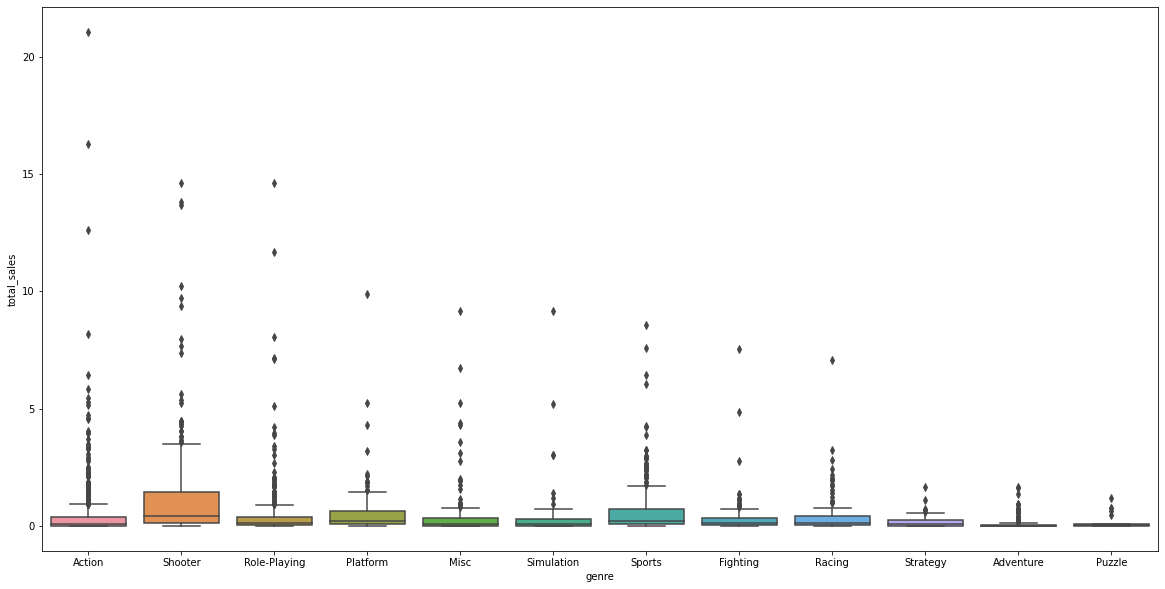

In [65]:
# также построим диаграммы размаха

rcp['figure.figsize'] = 20,10

ax = sns.boxplot(x='genre', y="total_sales", data=df)

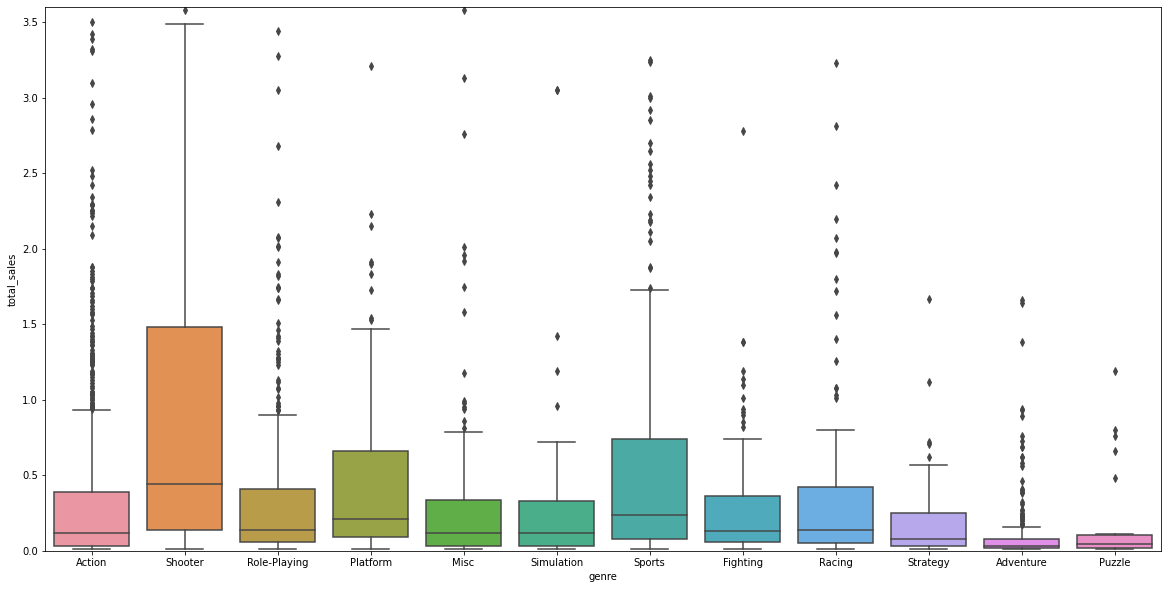

In [66]:
ax = sns.boxplot(x='genre', y="total_sales", data=df)

ax.set_ylim([0, 3.6]);

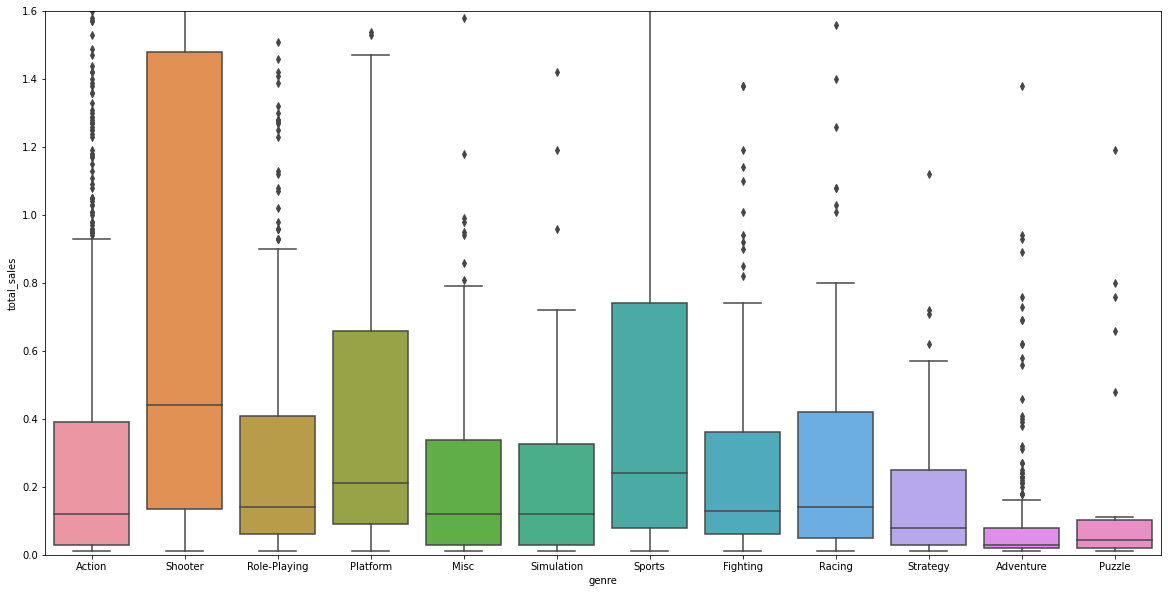

In [67]:
ax = sns.boxplot(x='genre', y="total_sales", data=df)

ax.set_ylim([0, 1.6]);

Диаграммы размаха показали, что для многих жанров медианы находятся довольно близко к нижней границе возможных значений, притом что наблюдается большое число выбросов со значениями от 200 тысяч и менее до 20 миллионов и более. Это подтверждает правильность выбора медианы в качестве показателя прибыльности жанров как таковых, а не суммы.

Из полученных данных можно сделать вывод о том, что среди жанров можно выделить как потенциально прибыльные: оные, для которых выпускается большое количество игр, которые хорошо (дороже других) продаются; так и потенциально неприбыльные жанры: оные, для которых выпускается мало игр, которые к тому же плохо продаются.

**К группе потенциально прибыльных жанров относятся**:
- Shooter
- Sports

**К группе потенциально неприбыльных жанров относятся**:
- Puzzle
- Strategy

### Исследование пользователей по регионам

#### Топ 5 популярных платформ

Выведем топ 5 платформ по количеству проданных копий игр для Северной Америки, Европы и Японии.

In [68]:
print('Северная Америка')

display(
    df.groupby('platform')['na_sales'].sum()
    .sort_values(ascending=False)
    .head()
)

print('Европа')

display(
    df.groupby('platform')['eu_sales'].sum()
    .sort_values(ascending=False)
    .head()
)

print('Япония')

(
    df.groupby('platform')['jp_sales'].sum()
    .sort_values(ascending=False)
    .head()
)

Северная Америка


platform
X360    140.050003
PS4     108.739998
PS3     103.379997
XOne     93.120003
3DS      55.310001
Name: na_sales, dtype: float32

Европа


platform
PS4     141.089996
PS3     106.860001
X360     74.519997
XOne     51.590000
3DS      42.639999
Name: eu_sales, dtype: float32

Япония


platform
3DS     87.790001
PS3     35.290001
PSV     21.039999
PS4     15.960000
WiiU    13.010000
Name: jp_sales, dtype: float32

Посчитаем доли продаж для топ 5 платформ относительно всего регионального рынка для Северной Америки, Европы и Японии.

In [69]:
print('Северная Америка')

display(
    (df.groupby('platform')['na_sales'].sum()
    .sort_values(ascending=False)
    .head()) * 100 /
    df['na_sales'].sum()
)

print('Европа')

display(
    (df.groupby('platform')['eu_sales'].sum()
    .sort_values(ascending=False)
    .head()) * 100 /
    df['eu_sales'].sum()
)

print('Япония')

display(
    (df.groupby('platform')['jp_sales'].sum()
    .sort_values(ascending=False)
    .head()) * 100 /
    df['jp_sales'].sum()
)

Северная Америка


platform
X360    23.698328
PS4     18.400259
PS3     17.493275
XOne    15.757146
3DS      9.359190
Name: na_sales, dtype: float32

Европа


platform
PS4     27.838285
PS3     21.084408
X360    14.703444
XOne    10.179156
3DS      8.413243
Name: eu_sales, dtype: float32

Япония


platform
3DS     45.586250
PS3     18.324852
PSV     10.925329
PS4      8.287465
WiiU     6.755634
Name: jp_sales, dtype: float32

Также выведем круговые диаграммы топ 5 платформ по количеству проданных копий игр для Северной Америки, Европы и Японии.

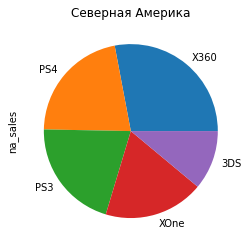

In [70]:
rcp['figure.figsize'] = 6,4

(
    df.groupby('platform')['na_sales'].sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie', grid=True, title='Северная Америка')
);

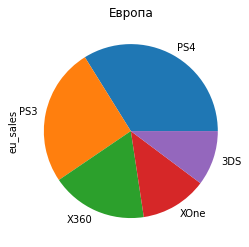

In [71]:
(
    df.groupby('platform')['eu_sales'].sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie', grid=True, title='Европа')
);

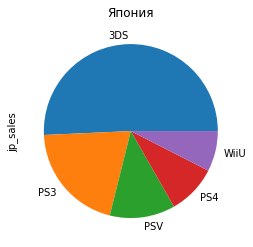

In [72]:
(
    df.groupby('platform')['jp_sales'].sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie', grid=True, title='Япония')
);

По круговым диаграммам заметно значительное различие в долях продаж по разным регионам.

- **В Северной Америке доминируют платформы семейства Xbox - X360 и XOne - на них приходится порядка 40 % рынка, а также платформы семейства PS - PS3 и PS4 - на них приходится 36 % рынка**. Также значительную долю рынка занимает 3DS - порядка 9 %.
- **В Европе доминируют платформы семейства PS - PS3 и PS4 - на них приходится порядка 49 % рынка**. Далее располагаются платформы семейства Xbox - X360 и XOne - на них приходится 25 % рынка. Замыкает топ 5 платформа 3DS с 8 %.
- **В Японии доминирует местная платформа 3DS: она занимает 46 % рынка**. Далее следуют платформы семейства PS - PS3, PSV и PS4 - на них приходится 38 % рынка. В конце топа располагается платформа WiiU с 7 %.

####  Топ 5 популярных жанров

Выведем топ 5 жанров по количеству проданных копий игр для Северной Америки, Европы и Японии.

In [73]:
print('Северная Америка')

display(
    df.groupby('genre')['na_sales'].sum()
    .sort_values(ascending=False)
    .head()
)

print('Европа')

display(
    df.groupby('genre')['eu_sales'].sum()
    .sort_values(ascending=False)
    .head()
)

print('Япония')

(
    df.groupby('genre')['jp_sales'].sum()
    .sort_values(ascending=False)
    .head()
)

Северная Америка


genre
Action          177.839996
Shooter         144.770004
Sports           81.529999
Role-Playing     64.000000
Misc             38.189999
Name: na_sales, dtype: float32

Европа


genre
Action          159.339996
Shooter         113.470001
Sports           69.089996
Role-Playing     48.529999
Racing           27.290001
Name: eu_sales, dtype: float32

Япония


genre
Role-Playing    65.440002
Action          52.799999
Misc            12.860000
Simulation      10.410000
Fighting         9.440000
Name: jp_sales, dtype: float32

Посчитаем доли продаж для топ 5 жанров относительно всего регионального рынка для Северной Америки, Европы и Японии.

In [74]:
print('Северная Америка')

display(
    (df.groupby('genre')['na_sales'].sum()
    .sort_values(ascending=False)
    .head()) * 100 /
    df['na_sales'].sum()
)

print('Европа')

display(
    (df.groupby('genre')['eu_sales'].sum()
    .sort_values(ascending=False)
    .head()) * 100 /
    df['eu_sales'].sum()
)

print('Япония')

display(
    (df.groupby('genre')['jp_sales'].sum()
    .sort_values(ascending=False)
    .head()) * 100 /
    df['jp_sales'].sum()
)

Северная Америка


genre
Action          30.092899
Shooter         24.497015
Sports          13.795963
Role-Playing    10.829654
Misc             6.462257
Name: na_sales, dtype: float32

Европа


genre
Action          31.439169
Shooter         22.388618
Sports          13.632057
Role-Playing     9.575392
Racing           5.384554
Name: eu_sales, dtype: float32

Япония


genre
Role-Playing    33.980682
Action          27.417177
Misc             6.677744
Simulation       5.405546
Fighting         4.901859
Name: jp_sales, dtype: float32

Также выведем круговые диаграммы топ 5 жанров по количеству проданных копий игр для Северной Америки, Европы и Японии.

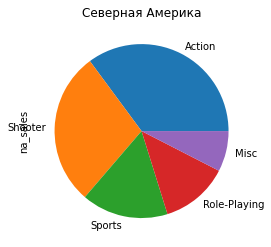

In [75]:
(
    df.groupby('genre')['na_sales'].sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie', grid=True, title='Северная Америка')
);

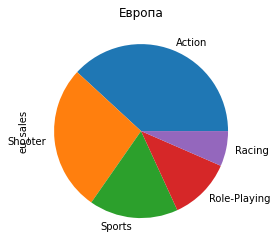

In [76]:
(
    df.groupby('genre')['eu_sales'].sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie', grid=True, title='Европа')
);

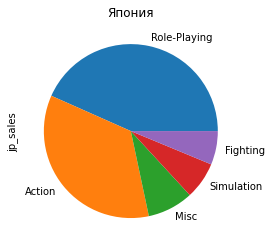

In [77]:
(
    df.groupby('genre')['jp_sales'].sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie', grid=True, title='Япония')
);

В полученных данных заметны значительные различия между Северной Америкой и Европой с одной стороны, и Японией с другой.

В первых двух регионах жанры топ 4 из топ 5 полностью совпадают, незначительно отличаются лишь доли рынка. Посмотрим на топ 5:
- Action: 30 % в Северной Америке и 31 % в Европе;
- Shooter: 24 % / 22 %;
- Sports: 14 % для обоих регионов;
- Role-Playing: 11 % / 10 %;
- Misc: 6 % в Северной Америке / racing: 5 % в Европе.

В Японии в топ 5 входят:
- Role-Playing: 34 %;
- Action: 27 %;
- Misc: 7 %;
- Simulation: 5 %;
- Fighting: 5 %.

Разницу в предпочтении жанров между пользователями из евроатлантических государств и Японии можно объяснить разным мировосприятием - принято считать, что люди из Европы и Америки и люди из Японии ментально отдалены друг от друга.

Популярность жанра Role-Playing в Японии также может быть связана с этим фактором: считается, что жители страны восходящего солнца любят косплеи, что может быть связано с предпочтением ими жанра Role-Playing.

#### Влияние рейтингов ESRB на продажи

Опишем значения столбца rating - рейтинги ESRB:
- «E» («Everyone») — «Для всех»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам» (от 13 лет и старше)
- «M» («Mature») — «Для взрослых» (от 17 лет и старше)

Важно уточнить, что ESRB определяет рейтинги для маркировки игр в Северной Америке. Поэтому во избежание искажения результатов исследования необходимо поставить "заглушку" на все пропуски в данном столбце.

In [78]:
df['rating'] = df['rating'].fillna('n/a')

Выведем топ значений рейтингов по количеству проданных копий игр для Северной Америки, Европы и Японии.

In [79]:
print('Северная Америка')

display(
    df.groupby('rating')['na_sales'].sum()
    .sort_values(ascending=False)
)

print('Европа')

display(
    df.groupby('rating')['eu_sales'].sum()
    .sort_values(ascending=False)
)

print('Япония')

(
    df.groupby('rating')['jp_sales'].sum()
    .sort_values(ascending=False)
)

Северная Америка


rating
M       231.569992
E       114.370003
n/a     103.309998
E10+     75.699997
T        66.019997
Name: na_sales, dtype: float32

Европа


rating
M       193.960007
E       113.029999
n/a      91.500000
E10+     55.369999
T        52.959999
Name: eu_sales, dtype: float32

Япония


rating
n/a     108.839996
E        28.330000
T        26.020000
M        21.200001
E10+      8.190000
Name: jp_sales, dtype: float32

Посчитаем доли продаж для каждого рейтинга для Северной Америки, Европы и Японии.

In [80]:
print('Северная Америка')

display(
    (df.groupby('rating')['na_sales'].sum()
    .sort_values(ascending=False)) * 100 /
    df.loc[~df['rating'].isna(), 'na_sales'].sum()
)

print('Европа')

display(
    (df.groupby('rating')['eu_sales'].sum()
    .sort_values(ascending=False)) * 100 /
    df.loc[~df['rating'].isna(), 'eu_sales'].sum()
)

print('Япония')

display(
    (df.groupby('rating')['jp_sales'].sum()
    .sort_values(ascending=False)) * 100 /
    df.loc[~df['rating'].isna(), 'jp_sales'].sum()
)

Северная Америка


rating
M       39.184731
E       19.352930
n/a     17.481430
E10+    12.809448
T       11.171464
Name: na_sales, dtype: float32

Европа


rating
M       38.269997
E       22.301804
n/a     18.053747
E10+    10.924983
T       10.449469
Name: eu_sales, dtype: float32

Япония


rating
n/a     56.516773
E       14.710770
T       13.511268
M       11.008412
E10+     4.252778
Name: jp_sales, dtype: float32

Также выведем круговые диаграммы топ рейтингов по количеству проданных копий игр для Северной Америки, Европы и Японии.

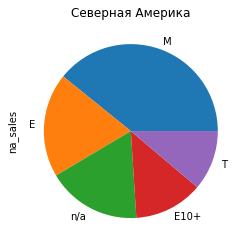

In [81]:
(
    df.groupby('rating')['na_sales'].sum()
    .sort_values(ascending=False)
    .plot(kind='pie', grid=True, title='Северная Америка')
);

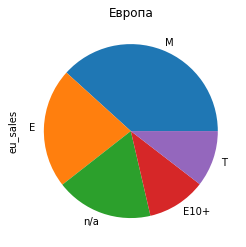

In [82]:
(
    df.groupby('rating')['eu_sales'].sum()
    .sort_values(ascending=False)
    .plot(kind='pie', grid=True, title='Европа')
);

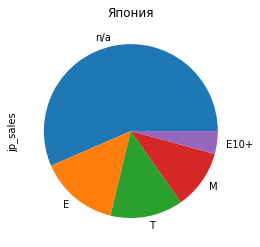

In [83]:
(
    df.groupby('rating')['jp_sales'].sum()
    .sort_values(ascending=False)
    .plot(kind='pie', grid=True, title='Япония')
);

При оценке долей продаж игр разных категорий налицо значительные различия между Северной Америкой и Европой с одной стороны, и Японией с другой.

Круговые диаграммы для первых двух регионов практически одинаковы:
- рейтинг M: 39 % рынка в Северной Америке и 38 % в Европе;
- рейтинг E: 19 % / 22 %;
- без рейтинга: 18 % / 18 %;
- рейтинг E10+: 13 % / 11 %;
- рейтинг T: 11 % / 11 %.

Для Японии значения совсем иные:
- без рейтинга: 57 % рынка в Японии;
- рейтинг E: 14 %;
- рейтинг T: 14 %;
- рейтинг M: 11 %;
- рейтинг E10+: 4 %.

Прежде всего необходимо дать пояснения столь высокому проценту игр без рейтинга на японском рынке. С одном стороны, выше уже было описано, что ESRB определяет рейтинги для маркировки игр в Северной Америке. С другой, исследование топ 5 популярных платформ показало, что более 50 % японского рынка приходится на местные платформы. Сложив два подвывода получаем, что доминирование игр без рейтинга на японском рынке связано с большим распространением местных платформ в регионе, игры для которых не маркируются.

Разницу в предпочтении игр с определенными рейтингами между пользователями из евроатлантических государств и Японии можно объяснить двумя причинами:
- как и для предыдущего вывода, разное мировосприятие;
- считается, что взрослые люди в Японии очень много работают. Возможно, в связи с этим доля игр для взрослых составляет в стране восходящего солнца лишь 11 % в сравнении со средним евроатлантическим 38.5 %;
- ввиду этого наиболее популярными рейтингами в Японии являются E и T: в игры с такими рейтингами можно играть людям всех возрастов и подросткам соответственно (такие игры могут быть распространены среди неработающих людей).

## Проверка гипотез

### Первая проверка

Первое утверждение звучит так: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Сформулируем нулевую и альтернативную гипотезы.
- Нулевая гипотеза:
 - средний пользовательский рейтинг платформы Xbox One **равен** среднему пользовательскому рейтингу платформы PC
- Альтернативная двусторонняя гипотеза:
 - средний пользовательский рейтинг платформы Xbox One **не равен** среднему пользовательскому рейтингу платформы PC

Проверим нулевую гипотезу.

In [85]:
# сохраним строки датафрейма с ненулевыми значениями рейтинга пользователей для платформы XOne

xone_user_scores = (
    df.query('platform == "XOne" and user_score > 0')
    ['user_score']
)

In [86]:
# сохраним строки датафрейма с ненулевыми значениями рейтинга пользователей для PC

pc_user_scores = (
    df.query('platform == "PC" and user_score > 0')
    ['user_score']
)

In [87]:
# выведем длины полученных сириэс

print(len(xone_user_scores))

len(pc_user_scores)

182


206

Т.к. объем выборки измеряется сотнями, примем критический уровень статистической значимости равный [0.01](https://www.statmethods.ru/stati/vybor-urovnya-znachimosti-pri-proverke-statisticheskikh-gipotez/).

In [88]:
# назначим значение критического уровня статистической значимости 

alpha = .01

Для проверки гипотезы проведем t-тест. Т.к. нам необходимо проверить равенство средних двух независимых совокупностей, то воспользуемся методом st.ttest_ind.

Прежде чем перейти к непосредственному проведению t-теста, проверим, равняются ли дисперсии двух выборок.

In [89]:
np.var(xone_user_scores, ddof=1) == np.var(pc_user_scores, ddof=1)

False

Дисперсии не равны, следовательно, передадим параметру equal_var метода ttest_ind аргумент False.

In [90]:
# проверим гипотезу о равенстве среднего двух независимых совокупностей

results = st.ttest_ind(
    xone_user_scores, 
    pc_user_scores,
    equal_var = False)

In [91]:
# выведем p-значение

print('p-значение:', results.pvalue)

p-значение: 0.5489560454239967


In [92]:
# проверим нулевую гипотезу

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

Не получилось отвергнуть нулевую гипотезу.


**Мы не можем отвергнуть нулевую гипотезу, которая звучит так: средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC**.

**Следовательно, средние пользовательские рейтинги игр на платформах Xbox One и PC примерно одинаковые**. Проверим это.

In [93]:
print('средний пользовательский рейтинг платформы Xbox One', df.query('platform == "XOne"')['user_score'].mean())
print('средний пользовательский рейтинг платформы PC', df.query('platform == "PC"')['user_score'].mean())

средний пользовательский рейтинг платформы Xbox One 6.5214286
средний пользовательский рейтинг платформы PC 6.428641


Проверка успешно пройдена.

Ввиду того, что данные платформы значительно отличаются как технически, так и по своему функционалу - XOne является консольной приставкой, а PC означает не что иное, как персональный компьютер - мы можем сделать вывод о том, что совпадение средних пользовательских оценок для игр данных платформ случайно, и не говорит о наличии какой-либо взаимосвязи между играми для данных платформ.

### Вторая проверка

Второе утверждение звучит так: средние пользовательские рейтинги жанров action и sports разные.

Сформулируем нулевую и альтернативную гипотезы.
- Нулевая гипотеза:
 - средний пользовательский рейтинг жанра action **не равен** среднему пользовательскому рейтингу жанра sports
- Альтернативная двусторонняя гипотеза:
 - средний пользовательский рейтинг жанра action **равен** среднему пользовательскому рейтингу жанра sports

Проверим нулевую гипотезу.

In [94]:
# сохраним строки датафрейма с ненулевыми значениями рейтинга пользователей для жанра action

action_user_scores = (
    df.query('genre == "Action" and user_score > 0')
    ['user_score']
)

In [95]:
# сохраним строки датафрейма с ненулевыми значениями рейтинга пользователей для жанра sports

sports_user_scores = (
    df.query('genre == "Sports" and user_score > 0')
    ['user_score']
)

In [96]:
# выведем длины полученных сириэс

print(len(action_user_scores))

len(sports_user_scores)

523


195

Т.к. объем выборки измеряется сотнями, примем критический уровень статистической значимости равный 0.01.

In [97]:
# назначим значение критического уровня статистической значимости 

alpha = .01

Для проверки гипотезы проведем t-тест. Т.к. нам необходимо проверить равенство средних двух независимых совокупностей, то воспользуемся методом st.ttest_ind.

Прежде чем перейти к непосредственному проведению t-теста, проверим, равняются ли дисперсии двух выборок.

In [98]:
np.var(action_user_scores, ddof=1) == np.var(sports_user_scores, ddof=1)

False

Дисперсии не равны, следовательно, передадим параметру equal_var метода ttest_ind аргумент False.

In [99]:
# проверим гипотезу о равенстве среднего двух независимых совокупностей

results = st.ttest_ind(
    action_user_scores, 
    sports_user_scores,
    equal_var = False)

In [100]:
# выведем p-значение

print('p-значение:', results.pvalue)

p-значение: 4.2428970996510126e-20


In [101]:
# проверим нулевую гипотезу

if results.pvalue == alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

Не получилось отвергнуть нулевую гипотезу.


**Мы не можем отвергнуть нулевую гипотезу, которая звучит так: средний пользовательский рейтинг жанра action не равен среднему пользовательскому рейтингу жанра sports**.

**Следовательно, средние пользовательские рейтинги игр в жанрах action и sports существенно различаются**. Проверим это.

In [102]:
print('средний пользовательский рейтинг жанра action', df.query('genre == "Action"')['user_score'].mean())
print('средний пользовательский рейтинг жанра sports', df.query('genre == "Sports"')['user_score'].mean())

средний пользовательский рейтинг жанра action 6.825048
средний пользовательский рейтинг жанра sports 5.4558973


Проверка пройдена.

В некоторой степени такой результат соответствует ожиданиям: данные жанры, несмотря на некоторые общие особенности (например, динамичность), имеют значительные технические отличия.

## Общий вывод

На основе входных данных о продажах игр, оценках пользователей и экспертов, жанрах и платформах был проведен ряд исследовательских анализов и исследований. Целью общего исследования было выявление закономерностей, определяющих успешность игры, что в дальнейшем позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Анализ релиза игр по годам**.

Результаты анализа:
- в датафрейме представлены данные о релизах игр с 1980 по 2016 года включительно;
- наибольшее количество игр было выпущено в 2008 году - почти 1500, наименьшее - в 1980 - 9;
- среднее количество игр, выпущенных за один год, составляет 444;
- медианное количество игр, выпущенных за один год, составляет 338;
- в 80-е годы было выпущено 179 игры, в 90-е - 1415, в 00-е - 7417, с 2010 по 2016 года - 3520.

Выводы из анализа:
- начиная с 2002 года заметен скачок количества выпущенных за год игр: вплоть до 2011 года этот параметр составляет не менее 750;
- кроме того, в период с 2002 по 2011 года были выпущены две трети игр;
- до 2011 года включительно наблюдается тенденция к увеличению количества выпущенных за год игр, после - тенденция к уменьшению;
- в связи с полученными данными можно выделить 5 временных периодов:
 - 1980-1993 - период становления игровой индустрии: ежегодно выходят не более 60 игр;
 - 1994-2001 - период бурного роста: количество выпускаемых игр увеличивается со 121 до 482;
 - 2002-2009 - "золотой" период индустрии: в год выпускается не менее 750 игр, в период с 2005 года - не менее 900, с 2006 - не менее 1000; пик приходится на 2008 год - почти 1.5 тысячи выпущенных игр;
 - 2010-2011 - период плавного спада: за 2010 год выходит менее 1300 игр, за 2011 - чуть более 1100;
 - 2012-2016 - период резкого спада: в 2012 году выходит 653 игра, далее - менее 600 игр в год.
 
**Анализ продаж по платформам**.

Результаты анализа:
- был выведен топ платформ с наибольшими суммарными продажами игр и построен график распределения по платформам;
- средние года релиза для 8 из топ 11 таких платформ лежат в промежутке между 2002 и 2011 годами - в этот период было выпущено подавляющее большинство игр;
- были построены графики распределения по годам для платформ с количеством проданных копий игр более 700 миллионов;
- пики на графиках для всех таких платформ, кроме PS, приходятся на период с 2003 по 2011 года, когда было выпущено преобладающее число игр.

Выводы из анализа:
- между количеством проданных копий игры и платформой выхода игры наблюдается связь;
- в данных наблюдается характерный срок, когда появляются новые платформы и исчезают старые: этот срок составляет 8-11 лет.

**Определение актуального периода**.

По результатам проведения данных анализов был принят актуальный период - промежуток с 2012 по 2016 год включительно. Основные критерии принятия данного временного отрезка в качестве актуального периода:
- года внутри данного промежутка находятся вместе с прогнозируемым 2017 годом в одном периоде (из вывода анализа релиза игр по годам), а именно в периоде резкого спада: 2012-2016;
- года внутри промежутка должны стать годами первых релизов игр на новых платформах - это связано с тем, что срок появления и исчезновения платформ составляет 8-11 лет.

На основе данных за соответствующий актуальный период можно будет сделать прогноз на 2017 год, т.к:
- года будет принадлежать одному периоду развития индустрии, следовательно, релизы и продажи должны будут осуществляться по одному закону;
- в 2017 году продолжат выходить игры на новых платформах, срок жизни которых еще не истечет.

После определения актуального периода датафрейм был перезаписан: в нем остались данные исключительно за данный временной промежуток.

**Исследование прибыльности платформ**.

Результаты исследования:
- был выведен топ оставшихся в датафрейме платформ с наибольшими суммарными продажами игр и построены графики распределения по платформам: столбчатая и круговая диаграммы;
- были построены графики распределения по годам для платформ с количеством проданных копий игр более 50 миллионов. Следует уточнить, что ввиду общего падения игровой индустрии в течение актуального периода было принято решение о построении графиков не по абсолютным величинам продаж, а по доле продаж по годам;

Выводы из исследования:
- среди всех оставшихся в датафрейме платформ были определены лидеры продаж: платформы с числом продаж более 50 миллионов копий;
- представленные платформы были разбиты на 3 условные группы: платформы, жизненный цикл которых подходит к концу - продажи падают; платформы, жизненный цикл которых берет свое начало - продажи растут; платформы, для которых не наблюдается четкой тенденции к падению или росту продаж;
- были определены потенциально прибыльные платформы: оные, относящиеся к группе роста продаж, а именно PS4 и XOne.

**Анализ характера разброса данных**.

В ходе анализа были построены диаграммы размаха ("ящики с усами") по продажам игр для каждой платформы. 

Результаты анализа:
- медианы продаж игр для платформ лежат в интервале от 30 тысяч до 310 тысяч;
- первые квартили находятся достаточно близко друг к другу: наименьшее значение составляет 20 тысяч, наибольшее - 100 тысяч;
- третьи квартили достаточно широко разбросаны: наименьшее значение - 173 тысячи, наибольшее - 870 тысяч;
- распределение границ статистически значимой выборки имеет схожую с распределением квартилей природу: нижние границы расположены близко друг к другу, верхние - разбросаны и находятся в промежутке между ~180 тысячами и ~2 миллионами;
- для всех платформ наблюдаются выбросы: для PSP все они лежат в интервале до 330 тысяч, для PS3, X360, PS4 и 3DS отдельные значения превышают 20-14 миллионов;
- данные для некоторых платформ (PSP, PSV, DS) сгруппированы достаточно плотно, для других (X360, PS4) - достаточно широко разбросаны;
- для графиков всех платформ характерна асимметрия - медиана значительно ближе расположена к первому квартилю, нежели к третьему.

Вывод из анализа:
- данные смещены в сторону нижней границы значений.

**Исследование влияния отзывов на продажи**.

**Отзывы критиков**.

Результаты исследования:
- для пары параметров: общие продажи-оценка критиков - были построены диаграммы рассеяния для 7 наиболее популярных платформ, а также были рассчитаны коэффициенты корреляции;
- по графикам нельзя сделать однозначный вывод о наличии взаимосвязи между исследуемыми параметрами: на всех графиках заметно, что игры с продажами до 1 миллиона копий встречаются довольно часто по всей оси абсцисс: вне зависимости от оценки критиков;
- однако, практически все игры с количеством проданных копий более 2 миллионов имеют оценку критиков не менее 70;
- коэффициенты корреляции Пирсона варьируются от 24 до 42 процентов, притом для платформ, которые показывают рост продаж - PS4 и XOne - коэффициенты являются наиболее высокими и составляют 41 и 42 процента соответственно;
- такие коэффициенты корреляции, как и общий для всех платформ коэффициент 31 %, говорят о наличии умеренной связи (для PC - слабой). Однако данный показатель достаточно мал для того, чтобы сделать вывод о наличии высокой или хотя бы заметной связи между исследуемыми параметрами.

Вывод:
- утверждать о влиянии отзывов критиков на продажи нельзя.

**Отзывы пользователей**.

Результаты исследования:
- по данным графикам скорее можно сделать вывод об отсутствии взаимосвязи между исследуемыми параметрами, а не о ее наличии: на всех графиках заметно, что игры с продажами до 1 миллиона копий встречаются довольно часто по всей оси абсцисс: вне зависимости от оценки критиков/пользователей, а для PS4 и XOne по всей оси абсцисс встречаются игры с с продажами вплоть до 5 миллионов;
- модули коэффициентов корреляции Пирсона варьируются от 0.5 до 40 процентов, притом для 4 из 7 платформ они не более 7, для 6 из 7 - не более 20;
- для растущих / падающих платформ не наблюдаются характерные коэффициенты корреляции, отличные от прочих;
- коэффициенты Пирсона, составляющие менее 10 %, в том числе общий для всех платформ коэффициент 0.4 %, говорят либо об отсутствии взаимосвязи между исследуемыми параметрами, либо о ее более сложном характере;
- коэффициенты корреляции, составляющие от 10 до 30 %,  говорят о наличии слабой связи между исследуемыми параметрами;
- коэффициент Пирсона для WiiU, равный 40 %, говорит о наличии умеренной связи. Однако данный показатель достаточно мал для того, чтобы сделать вывод о наличии высокой или хотя бы заметной связи между исследуемыми параметрами.

Вывод:
- утверждать о влиянии отзывов пользователей на продажи нельзя.

**Исследование прибыльности жанров**.

Результаты исследования:
- был выведен топ жанров с наибольшим количеством выпущенных игр и построен график распределения по жанрам;
- лидером среди жанров по количеству игр оказался action: на него приходится более 1000 наименований; на следующие следом за ним Role-Playing, Adventure, Sports и Shooter приходятся от 370 до 235 игр соответственно;
- внизу топа оказались жанры Puzzle, Strategy и Simulation с 28, 71 и 80 выпущенными играми соответственно;
- был выведен топ жанров по наибольшим медианным продажам игр и построен график распределения по жанрам;
- в данных по медианным продажам игр среди всех жанров выделяется Shooter: медианное значение мировых продаж составляет более 400 тысяч копий игр данного жанра; для жанров Sports и Platform, которые следуют в топе после шутера, медианное количество продаж составляет более 200 тысяч;
- жанр Action, который лидирует по количеству выпущенных игр, занимает в данном рейтинге лишь 7 позицию с показателем 120 тысяч;
- внизу данного топа располагаются жанры Adventure, Puzzle и Strategy с медианными значениями 30, 45 и 80 тысячами проданных копий соответственно;
- были построены диаграммы размаха продаж для каждого жанра, которые показали, что для многих жанров медианы находятся довольно близко к нижней границе возможных значений, притом что наблюдается большое число выбросов со значениями от 200 тысяч и менее до 20 миллионов и более.

Выводы из исследования:
- среди жанров можно выделить как потенциально прибыльные, так и потенциально неприбыльные;
- к первой группе относятся жанры, для которых выпускается большое количество игр, которые хорошо (дороже других) продаются:
- Shooter
- Sports
- ко второй группе относятся жанры, для которых выпускается мало игр, которые к тому же плохо продаются:
 - Puzzle
 - Strategy
 
**Исследование пользователей по регионам**.

- топ 5 платформ по продажам

- В Северной Америке доминируют платформы семейства Xbox - X360 и XOne - на них приходится порядка 40 % рынка, а также платформы семейства PS - PS3 и PS4 - на них приходится 36 % рынка. Также значительную долю рынка занимает 3DS - порядка 9 %.
- В Европе доминируют платформы семейства PS - PS3 и PS4 - на них приходится порядка 49 % рынка. Далее располагаются платформы семейства Xbox - X360 и XOne - на них приходится 25 % рынка. Замыкает топ 5 платформа 3DS с 8 %.
- В Японии доминирует местная платформа 3DS: она занимает 46 % рынка. Далее следуют платформы семейства PS - PS3, PSV и PS4 - на них приходится 38 % рынка. В конце топа располагается платформа WiiU с 7 %.
 
- топ 5 жанров по продажам
 - в полученных данных заметны значительные различия между Северной Америкой и Европой с одной стороны, и Японией с другой: в евроатлантических странах большей популярностью пользуются шутеры и спортивные игры, в Японии - ролевые игры;
 - разницу в предпочтении жанров между пользователями из евроатлантических государств и Японии можно объяснить разным мировосприятием - принято считать, что люди из Европы и Америки и люди из Японии ментально отдалены друг от друга;
 - популярность ролевого жанра в Японии также может быть связана с любовью жителей страны к косплеям

- влияние рейтингов ESRB на продажи
 - налицо значительные различия между Северной Америкой и Европой с одной стороны, и Японией с другой;
 - на японском рынке заметно доминирование игр без рейтинга: их доля составляет 57 % рынка. Это связано с тем, что ESRB определяет рейтинги для маркировки игр в Северной Америке, а более 50 % японского рынка приходится на местные платформы, игры для которых не маркируются;
 - круговые диаграммы для Северной Америки и Европы практически одинаковы, незначительно отличаются лишь доли рынка;
 - в евроатлантических странах наиболее хорошо продаются игры для взрослых, в Японии - игры для людей всех возрастов и тинэйджеров (такие игры могут быть распространены среди неработающих людей);
 - возможно, что различие в долях рынка для евроатлантики и Японии связана с тем, что, как считается, взрослые люди в Японии очень много работают, и, следовательно, не находят времени на игры.
 
**Проверка гипотез**

На основании **первого утверждения**: средние пользовательские рейтинги платформ Xbox One и PC одинаковые, были сформулированы нулевая и альтернативная гипотезы:
- средний пользовательский рейтинг платформы Xbox One **равен** среднему пользовательскому рейтингу платформы PC;
- средний пользовательский рейтинг платформы Xbox One **не равен** среднему пользовательскому рейтингу платформы PC.

По результатам проверки гипотезы мы не смогли отвергнуть нулевую гипотезу. Это значит, что средние пользовательские рейтинги игр на платформах Xbox One и PC примерно одинаковые.

Скорее всего, совпадение средних пользовательских оценок для игр данных платформ случайно, и не говорит о наличии какой-либо взаимосвязи между играми для данных платформ.

На основании **второго утверждения**: средние пользовательские рейтинги жанров action и sports разные, были сформулированы нулевая и альтернативная гипотезы:
- средний пользовательский рейтинг жанра action **не равен** среднему пользовательскому рейтингу жанра sports;
- средний пользовательский рейтинг жанра action **равен** среднему пользовательскому рейтингу жанра sports.

По результатам проверки гипотезы мы не смогли отвергнуть нулевую гипотезу. Это значит, что средние пользовательские рейтинги игр в жанрах action и sports существенно различаются. 

В некоторой степени такой результат соответствует ожиданиям: данные жанры, несмотря на некоторые общие особенности (например, динамичность), технически значительно отличаются.
 
**Общие рекомендации**:

Целью исследований было выявление закономерностей, определяющих успешность игры, что в дальнейшем позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Притом следует учитывать, что пользователи из разных регионов различаются между собой, следовательно, при планировании рекламных кампаний необходимо учитывать особенности конкретного региона.

К закономерностям, определяющим успешность игры, относятся: 

- **Потенциально прибыльные платформы - PS4 и XOne**
 - **в Северной Америке** широко распространены как платформы семейства Xbox, так и платформы семейства PS - в этом регионе **можно сделать ставку как на PS4, так и на XOne**;
 - **в Европе** доминируют платформы семейства PS - **можно сделать акцент на играх для PS4**;
 - в Японии доминирует местная платформа 3DS, которая не относится к группе потенциально прибыльных.
 

- **Потенциально прибыльные жанры - Shooter и Sports**
 - **пользуются наибольшей популярностью в Северной Америке и Европе**;
 - в Японии доминирует жанр ролевых игр.
 
 
- **Рейтинг**
- **более половины японского рынка приходится на игры без рейтинга**;
- **в евроатлантических странах доминируют игры для взрослых, в Японии наиболее популярными рейтингами являются "игры для людей всех возрастов" и "игры для тинэйджеров"**.

*Отзывы критиков и пользователей* НЕ являются показателями успешности игры.